# Sentiment Analysis using transformers

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import tarfile
from sklearn.datasets import load_files

In [ ]:
# Clone the repository
!git clone --depth 2 --single-branch --branch dev https://github.com/UniversalDependencies/UD_English-EWT.git

Cloning into 'UD_English-EWT'...
remote: Enumerating objects: 1312, done.
remote: Counting objects: 100% (1312/1312), done.
remote: Compressing objects: 100% (1162/1162), done.
remote: Total 1312 (delta 591), reused 424 (delta 148), pack-reused 0
Receiving objects: 100% (1312/1312), 8.45 MiB | 11.97 MiB/s, done.
Resolving deltas: 100% (591/591), done.


In [ ]:
!pip install conllu
import conllu
import pandas as pd
import numpy as np

def read_conllu_file(file_path):
    """
    Read a conllu file and read each sentences separated
    :param file_path: String
    :return: data in sentences specifically: <class 'conllu.models.SentenceList'>
    """
    # Read the CoNLL-U file
    with open(file_path, "r", encoding="utf-8") as f:
        # Parse the CoNLL-U formatted data
        data = f.read()
        sentences = conllu.parse(data)
    return sentences


# Function to extract tokens and UPOS tags from
# SentenceList object and create a DataFrame
def create_pos_df(sentences):
    """
    Read the conllu sentences list and import them in a dataframe
    including the information we need
    :param sentences: conllu.models.SentenceList
    :return: pd.DataFrame object
    """
    id_list = []
    tokens_list = []
    upos_tags_list = []

    for sentence in sentences:
        for token in sentence:  # Extract token and UPOS tag
            id = token['id']
            token_text = token['form']
            upos_tag = token['upos']

            id_list.append(id)
            tokens_list.append(token_text)
            upos_tags_list.append(upos_tag)


    # Create dataframe
    dataframe = pd.DataFrame({'id': id_list, "token": tokens_list, "UPOS": upos_tags_list})
    return dataframe

# Initialize the file paths
for split in ('train', 'dev', 'test'):
    file_path = f'UD_English-EWT/en_ewt-ud-{split}.conllu'
    print(file_path)
    sentences = read_conllu_file(file_path)

    # Create DataFrame for the current split
    pos_df = create_pos_df(sentences)
    # Assign DataFrame to variable with specific name
    globals()[f"{split}_pos"] = pos_df

UD_English-EWT/en_ewt-ud-train.conllu
UD_English-EWT/en_ewt-ud-dev.conllu
UD_English-EWT/en_ewt-ud-test.conllu


In [ ]:
print(f"train_pos dataframe: {len(train_pos)}")
print(f"test_pos dataframe: {len(test_pos)}")
print(f"dev_pos dataframe: {len(dev_pos)}")

# !rm -rf /content/UD_English-EWT # free up memory

train_pos dataframe: 207229
test_pos dataframe: 25450
dev_pos dataframe: 25511


In [ ]:
# Check the labels of our data
train_pos.UPOS.unique()

array(['PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'AUX',
       'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', '_', 'INTJ', 'X',
       'SYM'], dtype=object)

In [ ]:
# Drop rows that contain UPOS = '_'
train_pos = train_pos[train_pos.UPOS != '_']
test_pos = test_pos[test_pos.UPOS != '_']
dev_pos = dev_pos[dev_pos.UPOS != '_']

In [ ]:
print("Number of tags: ",len(train_pos.UPOS.unique()))

Number of tags:  17


In [ ]:
print(f'The length of the training set before the preprocess: {len(train_pos)}')

train_pos = train_pos[train_pos.id.apply(lambda x: isinstance(x, int))]
dev_pos = dev_pos[dev_pos.id.apply(lambda x: isinstance(x, int))]
test_pos = test_pos[test_pos.id.apply(lambda x: isinstance(x, int))]

# Reset the index of our dataframes because we dropped some rows
train_pos = train_pos.reset_index()
dev_pos = dev_pos.reset_index()
test_pos = test_pos.reset_index()

print(f'After the preprocess: {len(train_pos)}')

The length of the training set before the preprocess: 204615
After the preprocess: 204578


In [ ]:
train_pos.head(5)

,index,id,token,UPOS
0,0,1,Al,PROPN
1,1,2,-,PUNCT
2,2,3,Zaman,PROPN
3,3,4,:,PUNCT
4,4,5,American,ADJ


In [ ]:
test_pos.UPOS.value_counts()

NOUN     4137
PUNCT    3096
VERB     2605
PRON     2161
PROPN    2077
ADP      2033
DET      1897
ADJ      1787
AUX      1543
ADV      1178
CCONJ     737
PART      649
NUM       542
SCONJ     384
INTJ      120
SYM       109
X          39
Name: UPOS, dtype: int64

In [ ]:
from tqdm import tqdm


def make_sentences(dataframe):
    """
    Make sentences from the train, development and test set in order
    to create windows for each word
    :param dataframe: pandas df
    :return: array of sentences
    :return: array of position of each word
    :return: array of tags for each word
    """
    all_sents = []
    all_positions = []
    all_tags = []
    sentence = []
    position = []
    pos_tags = []
    cnt = 0
    with tqdm(total = len(dataframe)) as pbar:
        for index, row in dataframe.iterrows():
            id = row['id']
            token= row['token']
            upos = row['UPOS']
            if id > cnt:
                cnt = id
                sentence.append(token)
                position.append(index)
                pos_tags.append(upos)
            else:
                all_sents.append(sentence)
                all_positions.append(position)
                all_tags.append(pos_tags)
                sentence = []
                sentence.append(token)
                position= []
                position.append(index)
                pos_tags = []
                pos_tags.append(upos)
                cnt=id
            pbar.update(1)  # Update the progress bar
        all_sents.append(sentence)
        all_positions.append(position)
        all_tags.append(pos_tags)


        all_sents = [' '.join(words) for words in all_sents]
        # all_tags = [' '.join(words) for words in all_tags]


    return all_sents, all_positions, all_tags

X_train, all_train_positions, y_train = make_sentences(train_pos)
print(f'\nThe total sentences of the training set is: {len(X_train)}')
X_dev, all_dev_positions, y_dev = make_sentences(dev_pos)
print(f'\nThe total sentences of the development set is: {len(X_dev)}')
X_test, all_test_positions, y_test = make_sentences(test_pos)
print(f'\nThe total sentences of the test set is: {len(X_test)}')

100%|██████████| 204578/204578 [00:26<00:00, 7681.46it/s]



The total sentences of the training set is: 12544


100%|██████████| 25149/25149 [00:03<00:00, 7254.79it/s]



The total sentences of the development set is: 2001


100%|██████████| 25094/25094 [00:02<00:00, 9859.82it/s] 


The total sentences of the test set is: 2077


In [ ]:

print("Size of train: ",len(X_train))
print("Size of dev: ",len(X_dev))
print("Size of test: ",len(X_test))

Size of train:  12544
Size of dev:  2001
Size of test:  2077


In [ ]:
X_train[0:3]

['Al - Zaman : American forces killed Shaikh Abdullah al - Ani , the preacher at the mosque in the town of Qaim , near the Syrian border .',
 '[ This killing of a respected cleric will be causing us trouble for years to come . ]',
 'DPA : Iraqi authorities announced that they had busted up 3 terrorist cells operating in Baghdad .']

In [ ]:
y_train[0]

['PROPN',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'ADJ',
 'NOUN',
 'VERB',
 'PROPN',
 'PROPN',
 'PROPN',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'DET',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 'ADP',
 'DET',
 'NOUN',
 'ADP',
 'PROPN',
 'PUNCT',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 'PUNCT']

In [ ]:
# !pip install -U transformers
# !pip install -U tensorflow

In [ ]:
import transformers
transformers.__version__

'4.38.2'

In [ ]:
# ΤΟΚΕΝΙΖΕ
# !pip install keras
# !pip install keras-preprocessing

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(y_train)
y_train_encoded = tag_tokenizer.texts_to_sequences(y_train)
y_dev_encoded = tag_tokenizer.texts_to_sequences(y_dev)
y_test_encoded = tag_tokenizer.texts_to_sequences(y_test)

In [ ]:
MAX_SEQUENCE_LENGTH = 96

# x_train_padded = pad_sequences(x_train_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre',truncating='post')
y_train_padded = pad_sequences(y_train_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post',truncating='post')

# x_dev_padded = pad_sequences(x_dev_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre',truncating='post')
y_dev_padded = pad_sequences(y_dev_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post',truncating='post')

# x_test_padded = pad_sequences(x_test_encoded, maxlen=MAX_SEQ_LENGTH, padding='pre',truncating='post')
y_test_padded = pad_sequences(y_test_encoded, maxlen=MAX_SEQUENCE_LENGTH, padding='post',truncating='post')

In [ ]:
y_test_padded

array([[ 4, 14,  9, ...,  0,  0,  0],
       [ 4, 14,  9, ...,  0,  0,  0],
       [ 2,  5,  9, ...,  0,  0,  0],
       ...,
       [ 7,  1,  1, ...,  0,  0,  0],
       [ 9,  3,  7, ...,  0,  0,  0],
       [ 4,  3, 11, ...,  0,  0,  0]], dtype=int32)

# Transformers

In [ ]:
# TOKENIZE
from transformers import AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# EDW EXW BGALEI TA SPECIAL TOKENS. PREPEI?
def tokenize_text(data, tokenizer, max_length=MAX_SEQUENCE_LENGTH):
  return tokenizer(data, add_special_tokens=False, padding='max_length',
                   max_length=max_length, truncation=True, return_tensors='tf')

bert_train = tokenize_text(X_train, bert_tokenizer)
bert_val = tokenize_text(X_dev, bert_tokenizer)
bert_test = tokenize_text(X_test, bert_tokenizer)

bert_train

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': <tf.Tensor: shape=(12544, 96), dtype=int32, numpy=
array([[ 2632,  1011, 23564, ...,     0,     0,     0],
       [ 1031,  2023,  4288, ...,     0,     0,     0],
       [ 1040,  4502,  1024, ...,     0,     0,     0],
       ...,
       [10743,  2027,  2097, ...,     0,     0,     0],
       [ 1996,  5126,  2012, ...,     0,     0,     0],
       [ 1045,  2097,  2196, ...,     0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(12544, 96), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(12544, 96), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=in

In [ ]:
# ETOIMO MODELO GIA TOKEN CLASSIFICATION
import tensorflow as tf
from transformers import TFBertForTokenClassification, BertTokenizer
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# Load BERT model and tokenizer
model_name = 'bert-base-uncased'
bert_model = TFBertForTokenClassification.from_pretrained(model_name, num_labels=18)
bert_model.summary()

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_151 (Dropout)       multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  13842     
                                                                 
Total params: 108905490 (415.44 MB)
Trainable params: 108905490 (415.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the
bert_model.compile(optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


# Train the model
history = bert_model.fit(
    x=[bert_train['input_ids'], bert_train['attention_mask']],
    y=y_train_padded,
    epochs=15,
    batch_size=16,
    validation_data=([bert_val['input_ids'], bert_val['attention_mask']], y_dev_padded)
)
    # callbacks=[Metrics(([bert_val['input_ids'],
    #                      bert_val['attention_mask']],
    #                     y_val_1_hot))]


Epoch 1/15
784/784 [==============================] - 132s 128ms/step - loss: 0.2900 - sparse_categorical_accuracy: 0.8747 - val_loss: 0.0962 - val_sparse_categorical_accuracy: 0.9179
Epoch 2/15
784/784 [==============================] - 95s 121ms/step - loss: 0.1065 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.0713 - val_sparse_categorical_accuracy: 0.9424
Epoch 3/15
784/784 [==============================] - 90s 115ms/step - loss: 0.0708 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.0550 - val_sparse_categorical_accuracy: 0.9540
Epoch 4/15
784/784 [==============================] - 95s 121ms/step - loss: 0.0555 - sparse_categorical_accuracy: 0.9579 - val_loss: 0.0560 - val_sparse_categorical_accuracy: 0.9609
Epoch 5/15
784/784 [==============================] - 95s 121ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.0510 - val_sparse_categorical_accuracy: 0.9655
Epoch 6/15
784/784 [==============================] - 91s 116ms/step - loss: 0.0397 

In [ ]:
preds = bert_model.predict([bert_test['input_ids'],bert_test['attention_mask']]).logits

65/65 [==============================] - 28s 92ms/step


In [ ]:
from sklearn.metrics import classification_report

argmax_predictions = np.argmax(preds, axis=-1)

y_true_flat = y_test_padded.flatten()
y_pred_flat = argmax_predictions.flatten()
# non_padding_mask = y_true_flat != 0
# y_true_flat = y_true_flat[non_padding_mask]
# y_pred_flat = y_pred_flat[non_padding_mask]

# Generate classification report
report = classification_report(y_true_flat, y_pred_flat)

print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    174298
           1       0.87      0.89      0.88      4137
           2       0.90      0.90      0.90      3096
           3       0.93      0.94      0.93      2605
           4       0.95      0.95      0.95      2161
           5       0.90      0.92      0.91      2033
           6       0.94      0.94      0.94      1897
           7       0.91      0.89      0.90      1787
           8       0.94      0.95      0.95      1543
           9       0.87      0.81      0.84      2077
          10       0.89      0.90      0.89      1178
          11       0.93      0.91      0.92       737
          12       0.95      0.94      0.95       649
          13       0.72      0.86      0.78       542
          14       0.93      0.85      0.89       384
          15       0.72      0.61      0.66       109
          16       0.86      0.84      0.85       120
          17       0.75    

In [1]:
count_zeros = np.count_nonzero(y_pred_flat == 0)
count_zeros

NameError: name 'np' is not defined

KOMPLE MONTELO ALLA EKANE PREDICT KAPOIA MHDENIKA

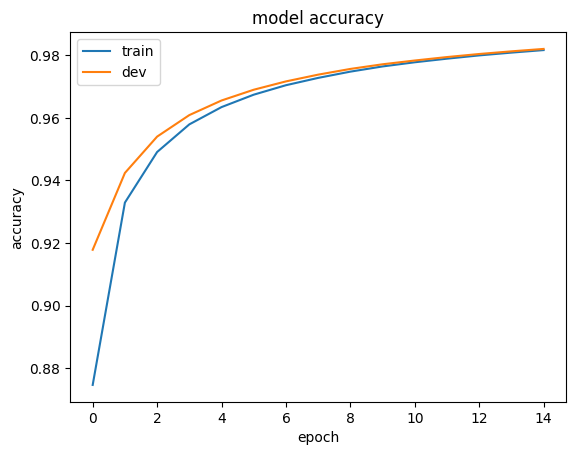

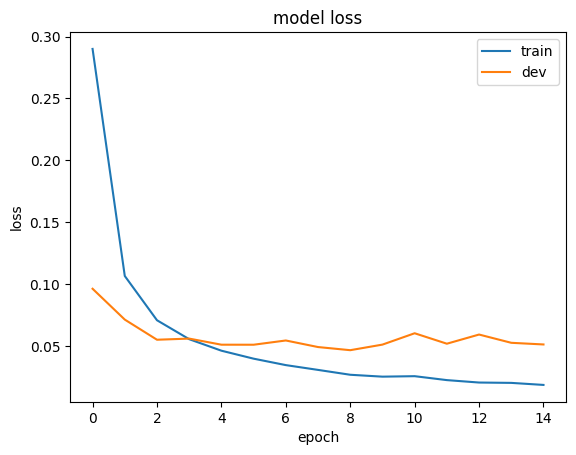

In [ ]:

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

SECOND MODEL

In [ ]:
from transformers import TFAutoModel

bert_backbone = TFAutoModel.from_pretrained('bert-base-uncased')
bert_backbone.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# # Compile the model
# optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=2e-5),
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
# metrics = ['categorical_accuracy']
# bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# # Train the model
# history = model.fit(
#     x=[bert_train['input_ids'],
#        bert_train['attention_mask']],
#     y=y_train_padded,
#     epochs=5,
#     batch_size=16,
#     validation_data=([bert_val['input_ids'],
#                       bert_val['attention_mask']],
#                      y_dev_padded),
#     # callbacks=[Metrics(([bert_val['input_ids'],
#     #                      bert_val['attention_mask']],
#     #                     y_val_1_hot))]
# )

In [ ]:
class BERTPosTagger(tf.keras.Model):
  def __init__(self, bert, num_classes, freeze=False, apply_dropout=True):
    super().__init__()
    self.bert = bert
    self.apply_dropout = apply_dropout
    self.bert.trainable = True
    if freeze:
        self.bert.trainable = False
    self.pool = tf.keras.layers.GlobalMaxPooling1D(name='max_pool')
    self.dropout = tf.keras.layers.Dropout(0.5, name='dropout')
    # self.bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True))
    self.dense = tf.keras.layers.Dense(100, activation = 'relu')
    self.masking_layer = tf.keras.layers.Masking(mask_value=0)  # Add masking layer
    self.clf = tf.keras.layers.Dense(num_classes, name='clf',
                                     activation='softmax')

  def call(self, inputs, training=None):
    # input_ids, attention_mask = inputs
    x = self.bert(inputs, training=training)
    # x = self.pool(x.last_hidden_state)
    x = self.dense(x.last_hidden_state, training= training)
    if self.apply_dropout:
        x = self.dropout(x, training=training)
    # x = self.dense(x, training= training)

    x = self.clf(x, training=training)
    return x




  def print_summary(self, line_length=None, positions=None, print_fn=None):
    # Fake forward pass to build graph
    x = np.zeros((1, 96), dtype=np.int32)
    self.predict([x, x])
    self.summary(line_length=line_length, positions=positions,
                 print_fn=print_fn)

In [ ]:
# Define a custom loss function with masking
def custom_sparse_categorical_loss(y_true, y_pred):
    # Remove padding from y_true

    mask = tf.math.not_equal(y_true, 0)
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    # Compute cross-entropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    loss=custom_sparse_categorical_loss,
    return loss

def custom_sparse_categorical_accuracy(y_true, y_pred):
    # Remove padding from y_true
    mask = tf.math.not_equal(y_true, 0)
    y_true = tf.boolean_mask(y_true, mask)
    y_pred = tf.boolean_mask(y_pred, mask)

    # Compute accuracy
    accuracy = tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

    return tf.reduce_mean(accuracy)


bert_pos_tagger = BERTPosTagger(bert_backbone,
                                 18,
                                 freeze=True, apply_dropout=True)
print(bert_pos_tagger.print_summary())
bert_pos_tagger.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                        loss=custom_sparse_categorical_loss,
                        metrics=[custom_sparse_categorical_accuracy])

history = bert_pos_tagger.fit(
    x=[bert_train['input_ids'], bert_train['attention_mask']],
    y=y_train_padded,
    batch_size=16,
    verbose=1,
    validation_data=([bert_val['input_ids'], bert_val['attention_mask']], y_dev_padded),
    shuffle=True,
    epochs=10
)

1/1 [==============================] - 30s 30s/step
Model: "bert_pos_tagger_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pool (GlobalMaxPooling  multiple                  0 (unused)
 1D)                                                             
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  76900     
                                                                 
 masking_12 (Masking)        multiple                  0 (unused)
                                                                 
 clf (Dense)                 multiple                  1818      
                                                                 
Total params: 109560958 (417.94 MB)
Trainable params: 78718 (3

TypeError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 161, in __call__
        return losses_utils.compute_weighted_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/losses_utils.py", line 328, in compute_weighted_loss
        losses = tf.convert_to_tensor(losses)

    TypeError: Failed to convert elements of (<function custom_sparse_categorical_loss at 0x7b2fcf2c28c0>,) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.


In [ ]:
predictions = bert_pos_tagger.predict([bert_test['input_ids'], bert_test['attention_mask']])

65/65 [==============================] - 25s 103ms/step


In [ ]:
argmax_predictions = np.argmax(predictions, axis=-1)
argmax_predictions.shape

(2077, 96)

In [ ]:
argmax_predictions

array([[0, 0, 1, ..., 0, 0, 0],
       [4, 3, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [4, 3, 1, ..., 0, 0, 0],
       [4, 3, 8, ..., 0, 0, 0]])

In [ ]:
from sklearn.metrics import classification_report

y_true_flat = y_test_padded.flatten()
y_pred_flat = argmax_predictions.flatten()
non_padding_mask = y_true_flat != 0
y_true_flat = y_true_flat[non_padding_mask]
y_pred_flat = y_pred_flat[non_padding_mask]

# GIA TO POUTSO REPORT
report = classification_report(y_true_flat, y_pred_flat)

print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.37      0.59      0.46      4137
           2       0.51      0.30      0.38      3096
           3       0.40      0.52      0.45      2605
           4       0.49      0.55      0.52      2161
           5       0.45      0.40      0.42      2033
           6       0.54      0.44      0.49      1897
           7       0.42      0.10      0.17      1787
           8       0.52      0.46      0.49      1543
           9       0.43      0.21      0.28      2077
          10       0.37      0.05      0.09      1178
          11       0.49      0.27      0.35       737
          12       0.55      0.18      0.27       649
          13       0.20      0.00      0.01       542
          14       0.36      0.01      0.03       384
          15       0.00      0.00      0.00       109
          16       0.00      0.00      0.00       120
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

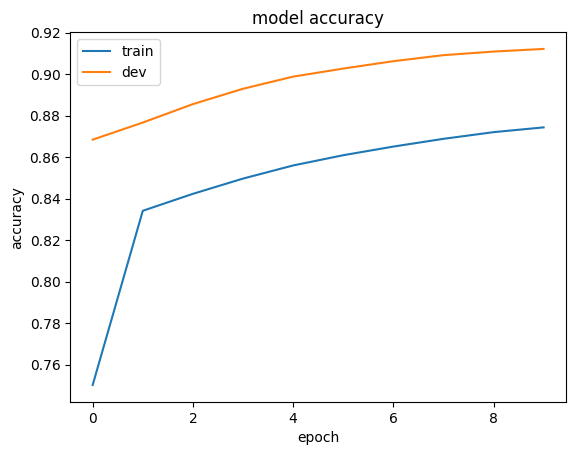

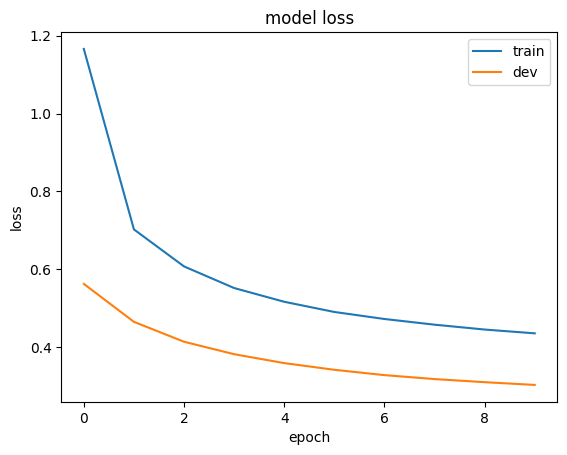

In [ ]:

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [ ]:
bert_val['input_ids'][0]

<tf.Tensor: shape=(96,), dtype=int32, numpy=
array([2013, 1996, 9706, 3310, 2023, 2466, 1024,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)>

In [ ]:
bert_val['attention_mask'][0]

<tf.Tensor: shape=(96,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

LETS BUILD A CLASS FOR TOKENIZATION